Install NumPyro by running:
`$ pip install numpyro`

In [1]:
from functools import partial

# Import regular numpy in additional to JAX's
import numpy
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb

In [2]:
# Compute on a CPU using 2 cores
numpyro.set_platform('cpu')
numpyro.set_host_device_count(2)

# Make plots larger by default
plt.rc('figure', dpi=100)

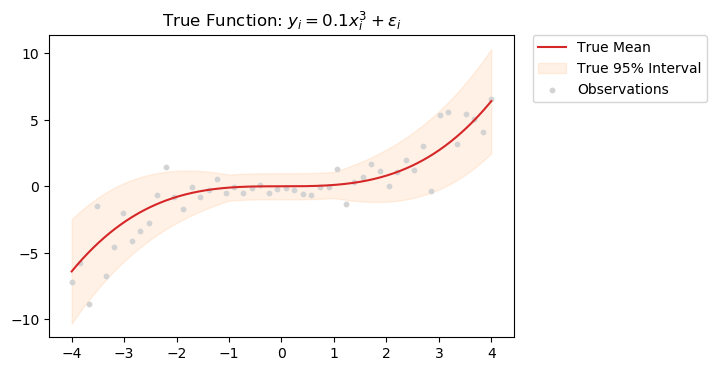

In [3]:
# Define the true function and generate observations
def func(x):
    std = np.abs(x) * 0.5
    std = np.where(std < 0.5, 0.5, std)
    return scipy.stats.norm(loc=0.1 * x**3, scale=std)

func.latex = r'$y_i = 0.1x_i^3 + \varepsilon_i$'

data_points = [
    { 'n_points': 50, 'xlim': [-4, 4] },
]
df = generate_data(func, points=data_points, seed=2)

# Plot the data
plot_true_function(func, df, title=f'True Function: {func.latex}')

In [24]:
# Observations
X = df[['x']].values
Y = df[['y']].values

# Number of hidden layers
hidden = 2
# Width of hidden layers
width = 10
# Standard deviation of the prior
sigma = 1.5
# Standard deviation of the likelihood
noise = 0.5

# Instantiate the model
model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

In [25]:
%%time
# Sampler parameters
num_chains = 2
num_samples = 2000
num_warmup = 2000

# Run the No-U-Turn sampler. Note: sampling more than one chain in parallel doesn't show a progress bar.
mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0[0,0]      0.08      3.12      0.06     -4.90      5.35    237.11      1.01
   b0[0,1]      0.25      3.27      0.40     -5.41      5.50    213.80      1.00
   b0[0,2]      0.05      3.08      0.14     -5.06      5.04    323.10      1.00
   b0[0,3]      0.17      3.15      0.21     -5.04      5.27    238.52      1.01
   b0[0,4]      0.06      3.11     -0.05     -4.83      5.51    309.42      1.00
   b0[0,5]     -0.30      3.21     -0.44     -5.26      5.25    314.25      1.00
   b0[0,6]     -0.35      3.07     -0.36     -5.73      4.36    263.48      1.02
   b0[0,7]      0.31      3.36      0.24     -4.97      6.12    254.52      1.01
   b0[0,8]      0.33      3.19      0.37     -5.06      5.52    305.50      1.01
   b0[0,9]      0.03      3.14      0.08     -5.00      5.29    235.72      1.00
   b1[0,0]      0.05      1.44      0.05     -2.46      2.30   2393.10      1.00
   b1[0,1]     -0.05      1

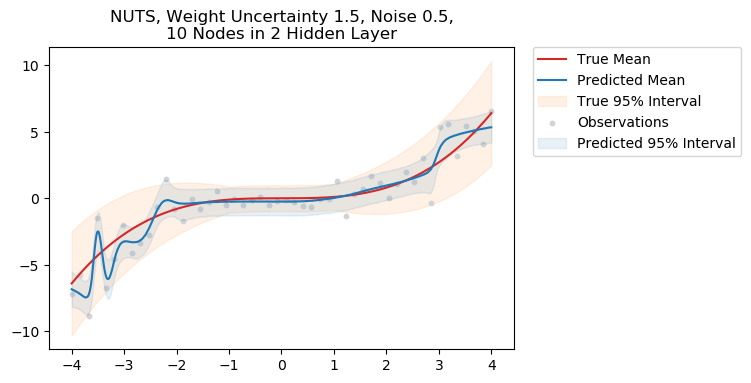

In [26]:
# Generate posterior predictive
X_test = numpy.linspace(df.x.min(), df.x.max(), num=1000)[:, np.newaxis]
posterior_predictive = simulate_posterior_predictive(model, mcmc, X_test, seed=1)

# Plot the results: truth vs prediction
plot_posterior_predictive(X_test, posterior_predictive, func=func, df=df,
                          title=f'NUTS, Weight Uncertainty {sigma}, Noise {noise},\n'
                                f'{width} Nodes in {hidden} Hidden Layer')